# NUS Team 144
## SDS Datathon 2024 Champion's Group
### By Ashwin, Jeron, Mun Jia, Kellianne, Tammy

In [22]:
%pip install pandas
%pip install matplotlib
%pip install sklearn
%pip install seaborn
# add commented pip installation lines for packages used as shown above for ease of testing
# the line should be of the format %pip install PACKAGE_NAME

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from matplotlib.colors import LogNorm
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score, KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer, mean_squared_error, r2_score

## **DO NOT CHANGE** the filepath variable
##### Instead, create a folder named 'data' in your current working directory and
##### have the .csv file inside that. A relative path *must* be used when loading data into pandas

In [ ]:
# Can have as many cells as you want for code

filepath = "./data/catA_train.csv"
# the initialised filepath MUST be a relative path to a folder named data that contains the parquet file

### **ALL** Code for machine learning and dataset analysis should be entered below.
##### Ensure that your code is clear and readable.
##### Comments and Markdown notes are advised to direct attention to pieces of code you deem useful.

In [ ]:
data = pd.read_csv(filepath)

# Section 1: Cleaning Data

In [ ]:
data.isnull().sum()

# percentage of missing values in each column.
missing_values = data.isnull().mean() * 100

# Columns with a high percentage of missing values might be candidates for removal
columns_to_remove = missing_values[missing_values > 50].index.tolist()

# For columns with a lower percentage of missing values, we'll consider imputation
columns_to_impute = missing_values[(missing_values > 0) & (missing_values <= 50)].index.tolist()

# For numerical columns, impute missing values with the median
for col in columns_to_impute:
    if data[col].dtype in ['int64', 'float64']:
        data[col].fillna(data[col].median(), inplace=True)

# For categorical columns, impute missing values with the mode
for col in columns_to_impute:
    if data[col].dtype == 'object':
        data[col].fillna(data[col].mode()[0], inplace=True)

# remove the columns with a high percentage of missing values
data_cleaned = data.drop(columns=columns_to_remove)

#Companies in dataset are all "Active"

# see the updated dataframe information
data_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29182 entries, 0 to 29181
Data columns (total 25 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   LATITUDE                             29182 non-null  float64
 1   LONGITUDE                            29182 non-null  float64
 2   AccountID                            29182 non-null  object 
 3   Company                              29182 non-null  object 
 4   SIC Code                             29182 non-null  float64
 5   Industry                             29182 non-null  object 
 6   8-Digit SIC Code                     29182 non-null  float64
 7   8-Digit SIC Description              29182 non-null  object 
 8   Year Found                           29182 non-null  float64
 9   Entity Type                          29182 non-null  object 
 10  Parent Company                       29182 non-null  object 
 11  Parent Country              

# Section 2: Analysis and Visualizations

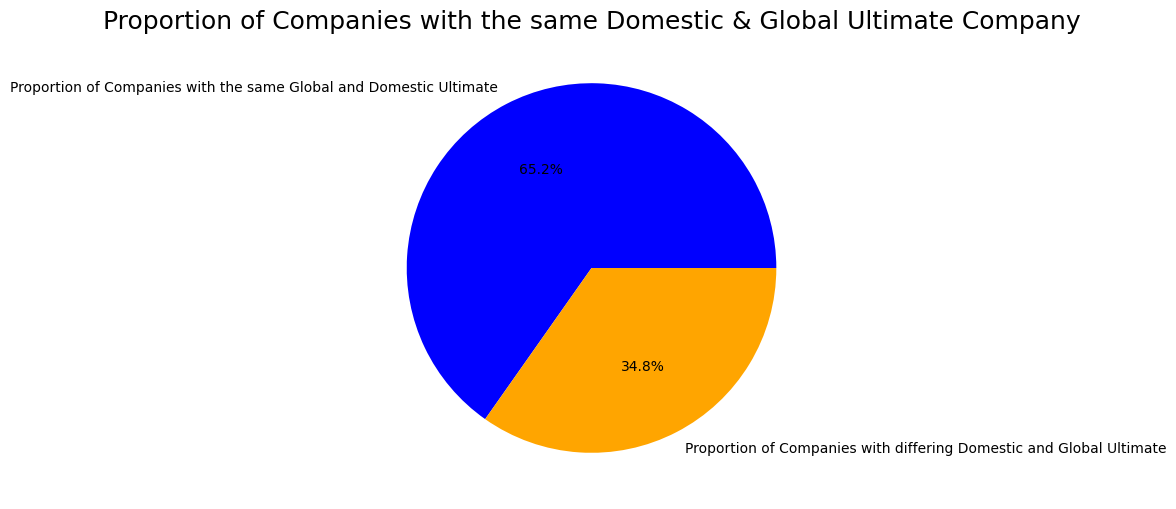

In [ ]:
# Calculate the count of companies with equal and distinct values for domestic vs global sales

same_ultimate_count = data_cleaned[data_cleaned['Global Ultimate Company'] == data_cleaned['Domestic Ultimate Company']].shape[0]
different_ultimate_count = data_cleaned.shape[0] - same_ultimate_count

# Pie chart 1 shows % of companies with same global ultimate and domestic ultimate
plt.figure(figsize=(8, 6))
plt.pie([same_ultimate_count, different_ultimate_count], labels=['Proportion of Companies with the same Global and Domestic Ultimate', 'Proportion of Companies with differing Domestic and Global Ultimate'], autopct='%1.1f%%', colors=['blue', 'orange'])
plt.title('Proportion of Companies with the same Domestic & Global Ultimate Company', fontsize = 18)
plt.show()


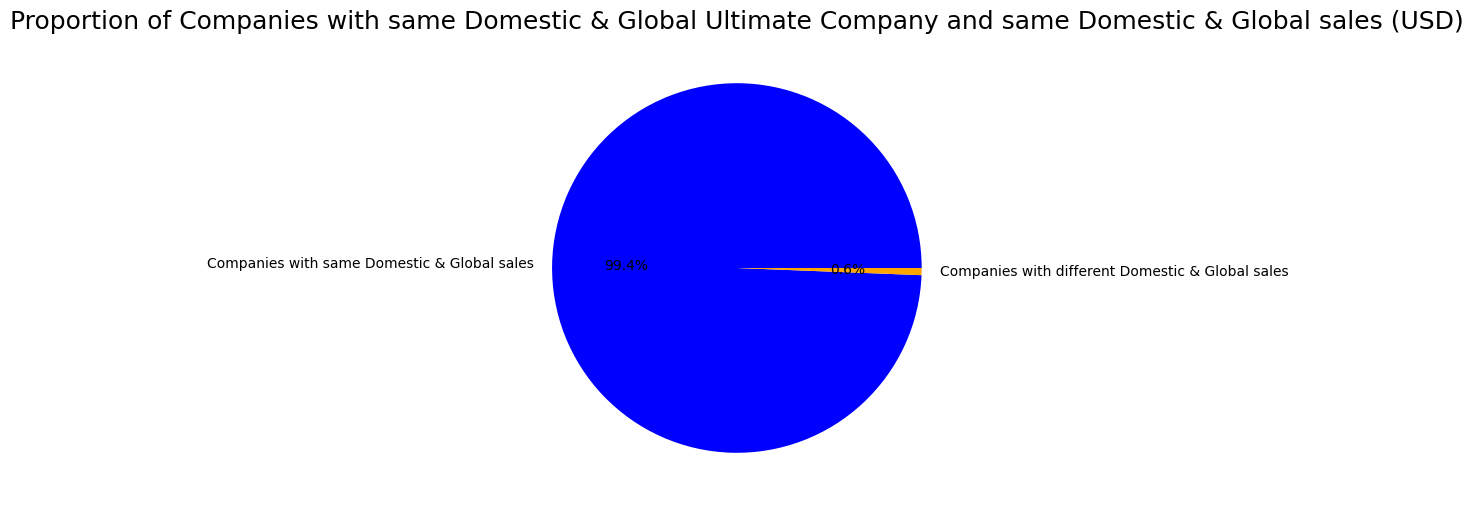

In [ ]:
# Pie chart 2 shows % of companies with the same global sales and domestic sales out of all companies with the same global and domestic ultimate
same_sales_count = data_cleaned[data_cleaned['Sales (Domestic Ultimate Total USD)'] == data_cleaned['Sales (Global Ultimate Total USD)']].shape[0]
same_ultimate_and_same_sales_count = data_cleaned[(data_cleaned['Sales (Domestic Ultimate Total USD)'] == data_cleaned['Sales (Global Ultimate Total USD)']) & (data_cleaned['Global Ultimate Company'] == data_cleaned['Domestic Ultimate Company'])].shape[0]

same_ultimate_but_different_sales_count = same_ultimate_count - same_ultimate_and_same_sales_count

# Plotting the proportions using a pie chart
plt.figure(figsize=(8, 6))
plt.pie([same_ultimate_and_same_sales_count, same_ultimate_but_different_sales_count], labels=['Companies with same Domestic & Global sales', 'Companies with different Domestic & Global sales'], autopct='%1.1f%%', colors=['blue', 'orange'])
plt.title('Proportion of Companies with same Domestic & Global Ultimate Company and same Domestic & Global sales (USD)', fontsize = 18)
#plt.suptitle('(*A majority of the data where Domestic Ultimate Company is the same as Global Ultimate Company implies same Global and Domestic Sales)', fontsize = 8)
plt.show()

#Proportion of Ultimate Companies that share Domestic and Global sales*

### Observations

####We have observed that roughly 2/3 of the companies have the same Domestic & Global Ultimate Company, which corresponds to them having the same sales amount for both Domestic & Global Ultimate Total sales

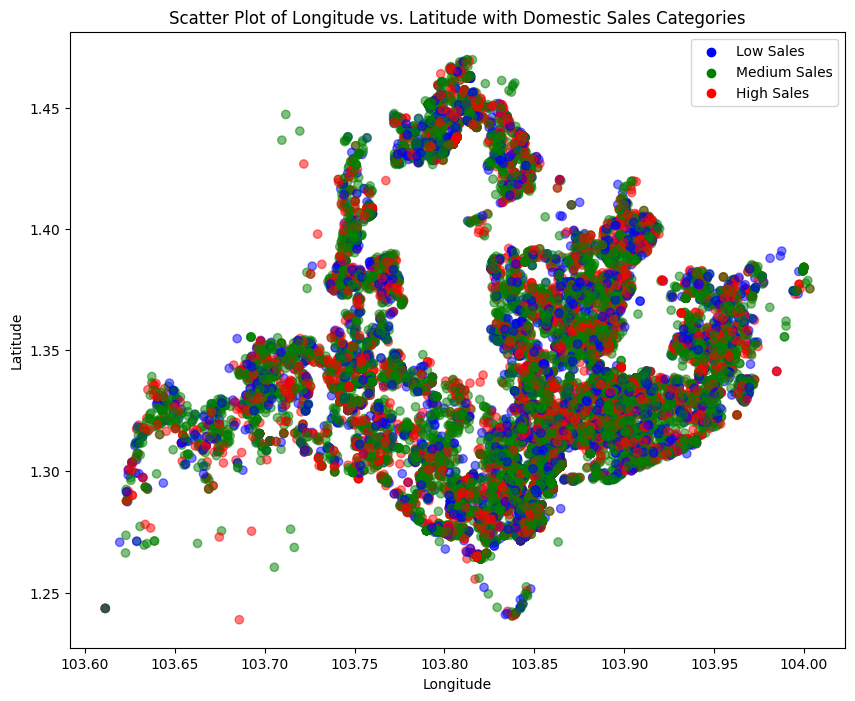

In [ ]:
# Calculate the 25th and 75th percentiles of domestic sales
sales_25th_percentile = data_cleaned['Sales (Domestic Ultimate Total USD)'].quantile(0.25)
sales_75th_percentile = data_cleaned['Sales (Domestic Ultimate Total USD)'].quantile(0.75)

# Define thresholds for low, medium, and high sales
low_threshold = sales_25th_percentile
high_threshold = sales_75th_percentile

# Plotting the scatter plot
plt.figure(figsize=(10, 8))

# Assign colors based on sales categories
colors = np.where(data_cleaned['Sales (Domestic Ultimate Total USD)'] < low_threshold, 'blue',
                  np.where(data_cleaned['Sales (Domestic Ultimate Total USD)'] >= high_threshold, 'red', 'green'))

plt.scatter(data_cleaned['LONGITUDE'], data_cleaned['LATITUDE'], c=colors, alpha=0.5)
plt.title('Scatter Plot of Longitude vs. Latitude with Domestic Sales Categories')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Creating custom legend
plt.scatter([], [], c='blue', label='Low Sales')
plt.scatter([], [], c='green', label='Medium Sales')
plt.scatter([], [], c='red', label='High Sales')
plt.legend()

plt.show()

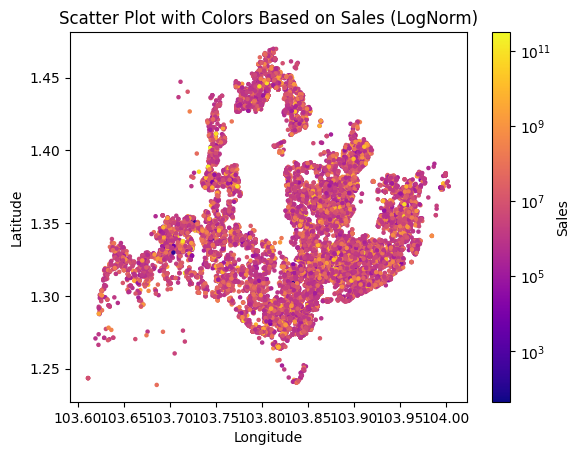

In [ ]:
# Use LogNorm for more sensitivity to numerical changes

norm = LogNorm()

# Define a colormap transitioning from blue to red
cmap = 'plasma'

# Scatter plot with colors based on Sales values and LogNorm
scatter = plt.scatter(data_cleaned['LONGITUDE'], data_cleaned['LATITUDE'], c=data_cleaned['Sales (Domestic Ultimate Total USD)'], cmap=cmap, s=5, norm=norm)

cbar = plt.colorbar(scatter, label='Sales')

# Set labels and title
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Scatter Plot with Colors Based on Sales (LogNorm)')

# Show the plot
plt.show()

# Section 3: Feature Engineering

In [ ]:
# Feature: Sum_of_employees
# Summing up the total number of employees that are under the same "Global Ultimate Company"
data_cleaned['Sum_of_employees'] = data_cleaned.groupby('Domestic Ultimate Company')['Employees (Single Site)'].transform('sum') + data_cleaned['Employees (Global Ultimate Total)']

# Feature: Employee_efficiency_ratio
# Finding out how much the entire structure of a Global Ultimate Company is making per employee - "Sales(Global Ultimate Total USD)"/ "Sum_of_employees"
data_cleaned['Employee_efficiency_ratio'] = data_cleaned['Sales (Global Ultimate Total USD)'] / data_cleaned['Sum_of_employees']

# Feature: Same_ultimate
# Finding out which companies have the same Global and Domestic Ultimate Company since we found out earlier that companies with the same Domestic and GLobal Ulitmate companies have the same Domestic and Global Sales. Modelling this relationship can improve the accuracy of the model.
data_cleaned["Same_ultimate"] = data_cleaned.apply(lambda row: 1 if row['Global Ultimate Company'] == row['Domestic Ultimate Company'] else 0, axis=1)

# Feature: Age of company
data_cleaned["Age"] = 2024 - data_cleaned["Year Found"]

#Feature: Whether it is a mature company (>5 years old) or a start-up (<5 years old)
bins = [0,5, float("inf")]
labels = ['Start-up', 'Mature']
data_cleaned['Maturity'] = pd.cut(data_cleaned['Age'], bins=bins, labels=labels, right=False, ordered = True)
data_cleaned["Is_Mature"] = np.where(data_cleaned['Maturity'] == 'Mature', 1, 0)



######The Employee_efficiency_ratio, also known as sales per employee ratio is an asset utilization metric that allows analysts to understand how efficiently a company uses its staff to generate revenues. Sales per employee is a popular industry measure; oftentimes used by both the investor-analyst and company management to benchmark performance.


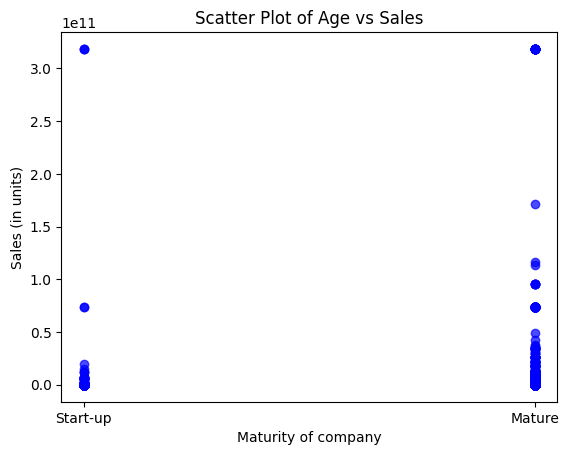

In [ ]:
# Relationship between sales and maturity of company

# Create a scatter plot
plt.scatter(data_cleaned["Maturity"], data_cleaned["Sales (Domestic Ultimate Total USD)"], color='blue', alpha=0.7)
plt.title('Scatter Plot of Age vs Sales')
plt.xlabel('Maturity of company')
plt.ylabel('Sales (in units)')

# Show the plot
plt.show()

In [ ]:
# Top 5 Global Ultimate Companies with High Sales (Domestic Ultimate Total USD)

# Dropping duplicate rows based on 'Global Ultimate Company'
unique_data = data_cleaned.drop_duplicates(subset='Global Ultimate Company')

# Groupby 'Global Ultimate Company' and calculate Total 'Sales (Domestic Ultimate Total USD) and 'Employee_efficiency_ratio' within each group
ultimate_grouped = unique_data.groupby('Global Ultimate Company')['Sales (Domestic Ultimate Total USD)', 'Employee_efficiency_ratio'].sum()

# Find the top 5 Global Ultimate Companies based on Total 'Sales (Domestic Ultimate Total USD)
top_5_ultimate_companies = ultimate_grouped.nlargest(5, 'Sales (Domestic Ultimate Total USD)').index.tolist()

# Filter the original dataset to include only the top 5 Global Ultimate Companies
top_5_dataframe = data_cleaned[data_cleaned['Global Ultimate Company'].isin(top_5_ultimate_companies)]

# Display dataframe for the top 5 Global ultimate companies
print("Aggregated DataFrame for Top 5 Global Ultimate Companies:")
print(ultimate_grouped.loc[top_5_ultimate_companies])
print("\nData for Top 5 Global Ultimate Companies:")
print(top_5_dataframe)

Aggregated DataFrame for Top 5 Global Ultimate Companies:
                                                Sales (Domestic Ultimate Total USD)  \
Global Ultimate Company                                                               
Farringford N.V.                                                       3.180000e+11   
Apple Inc.                                                             1.140000e+11   
AMOS GROUP LIMITED                                                     9.527987e+10   
WILMAR INTERNATIONAL LIMITED                                           7.339898e+10   
CNOOC Petrochemicals Import & Export Co., Ltd.                         4.920055e+10   

                                                Employee_efficiency_ratio  
Global Ultimate Company                                                    
Farringford N.V.                                             1.313385e+03  
Apple Inc.                                                   2.402205e+06  
AMOS GROUP LIMITED          

<ipython-input-14-31d3e1cab706>:7: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  ultimate_grouped = unique_data.groupby('Global Ultimate Company')['Sales (Domestic Ultimate Total USD)', 'Employee_efficiency_ratio'].sum()


In [ ]:
# Bottom 5 Global_Ultimate_Company with lowest sales (Domestic Ultimate Total USD)

# Drop duplicate rows based on 'Global Ultimate Company'
unique_data = data_cleaned.drop_duplicates(subset='Global Ultimate Company')

# Group by 'Global Ultimate Company' and calculate the total sales and employee efficiency ratio within each group
ultimate_grouped = unique_data.groupby('Global Ultimate Company')['Sales (Domestic Ultimate Total USD)', 'Employee_efficiency_ratio'].sum()

# Find the bottom 5 Global Ultimate Company companies based on total sales
bottom_5_ultimate_companies = ultimate_grouped.nsmallest(5, 'Sales (Domestic Ultimate Total USD)').index.tolist()

# Filter the original dataset to include only the bottom 5 Global Ultimate Companies
bottom_5_dataframe = data_cleaned[data_cleaned['Global Ultimate Company'].isin(bottom_5_ultimate_companies)]

# Display dataframe for the bottom 5 Global Ultimate Companies
print("Aggregated DataFrame for Bottom 5 Global Ultimate Companies:")
print(ultimate_grouped.loc[bottom_5_ultimate_companies])
print("\nData for Bottom 5 Global Ultimate Companies:")
print(bottom_5_dataframe)

Aggregated DataFrame for Bottom 5 Global Ultimate Companies:
                                                    Sales (Domestic Ultimate Total USD)  \
Global Ultimate Company                                                                   
GUOLINE CAPITAL ASSETS LTD                                                 -150263100.0   
TECH PACIFIC (INDIA) LIMITED                                                  -453533.0   
JBF INDUSTRIES LIMITED                                                             46.0   
State-Owned Assets Supervision and Administrati...                                 46.0   
PINE LABS LIMITED                                                                 137.0   

                                                    Employee_efficiency_ratio  
Global Ultimate Company                                                        
GUOLINE CAPITAL ASSETS LTD                                       33415.111111  
TECH PACIFIC (INDIA) LIMITED                                 

<ipython-input-15-a9dcf39af9e5>:7: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  ultimate_grouped = unique_data.groupby('Global Ultimate Company')['Sales (Domestic Ultimate Total USD)', 'Employee_efficiency_ratio'].sum()


###Analysis

##### By looking at the Top 5 Global Ultimate Companies and Bottom 5 Global Ultimate Companies, we can see that the Employee_efficiency_ratio and Sum_of_employees are strongly correlated to the Sales (Domestic Ultimate Total USD).
##### For example, the Top Global Ultimate Company: Farringford N.V. has a high Employee_efficiency_ratio of 1.727035e+07 as compared to the Worst Global Ultimate Company: GUOLINE CAPITAL ASSETS LTD 's Employee_efficiency_ratio of 33415.111111.
##### The Sum_of_employees of Farringford N.V. is 4250.0 compared to GUOLINE CAPITAL ASSETS LTD's mere Sum_of_employees of 29.

##### Positive reviews and high employee satisfaction, exemplified by Farringford N.V whose Domestic Ultimate Company is Trafigura Pte. Ltd has ratings (Work-Life Balance: 3.3/5, Salary & Benefits: 4/5, Job Security & Advancement: 3.2/5, Overall: 3.8/5), indicate a motivated and content workforce (Sg, Indeed).
##### This could contribute to the relatively high employee_efficiency_ratio, positively impacting customer satisfaction, repeat business, and overall sales. Conversely,  The observed correlation highlights the pivotal role of employee efficiency in driving successful sales performance.

<ipython-input-16-cb642ee19388>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = data_cleaned.corr()


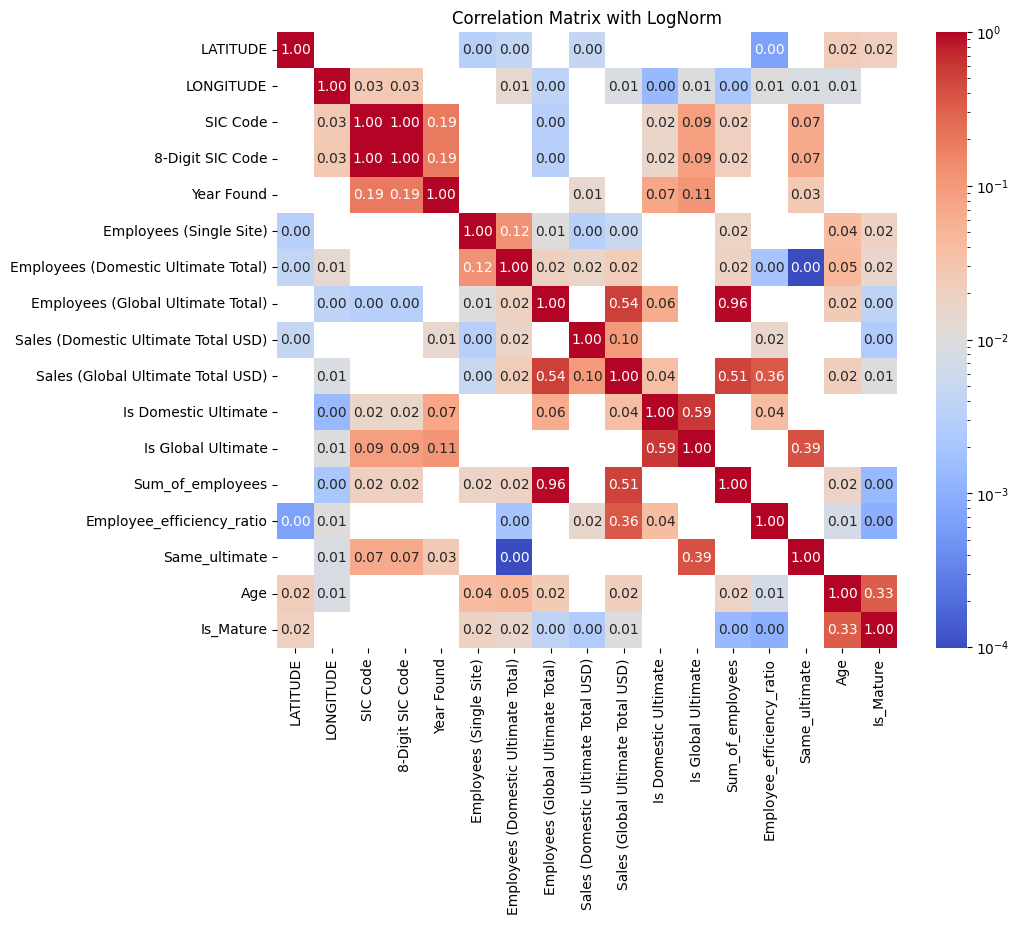

In [ ]:
# Correlation matrix with added variables

correlation_matrix = data_cleaned.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=True, fmt=".2f", norm=LogNorm())
plt.title('Correlation Matrix with LogNorm')
plt.show()


## Section 4 & 5: Modelling and Performance

####The Random Forest model is well-suited for the dataset at hand due to its ability to handle a mix of numerical and categorical variables, as well as its robustness to outliers and missing values. The predictor variables selected for the model (e.g., global sales, sum of employees, employee efficiency ratio, and same ultimate company indicator) provide a diverse set of features that can capture different aspects of the relationship with domestic sales. Random Forest's inherent ability to handle interactions among these features makes it an appropriate choice for modeling the complex relationships in the dataset.

In [ ]:
#Random Tree Regressor

X = data_cleaned[['Sales (Global Ultimate Total USD)', 'Sum_of_employees', 'Employee_efficiency_ratio', 'Same_ultimate', 'Is_Mature']]
y = data_cleaned['Sales (Domestic Ultimate Total USD)']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)

# Create and train the Random Forest Regressor model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict on the test set
predictions = model.predict(X_test)

# Evaluate the model

# Calculate MSE, RMSE, and R^2
mse = mean_squared_error(y_test, predictions)
rmse = mean_squared_error(y_test, predictions, squared=False)  # RMSE is the square root of MSE
r2 = r2_score(y_test, predictions)

# Calculate the number of observations and predictors
n = X_test.shape[0]  # Number of observations
k = X_test.shape[1]  # Number of predictors

# Calculate AIC
residuals = y_test - predictions
sse = np.sum(residuals ** 2)
aic = 2 * k - 2 * np.log(sse)

# Calculate Adjusted R^2
r2_adj = 1 - (1 - r2) * ((n - 1) / (n - k - 1))

print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {rmse}')
print(f'R-squared: {r2}')
print(f'Akaike Information Criterion (AIC): {aic}')
print(f'Adjusted R-squared: {r2_adj}')

# Checking which features are contributing the most to predictions
# Get feature importances
feature_importances = model.feature_importances_

# Create a DataFrame to display feature importances
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Print or visualize the feature importances
print(feature_importance_df)

Mean Squared Error: 3.091738445336772e+18
Root Mean Squared Error: 1758333997.0940595
R-squared: 0.9611629656832331
Akaike Information Criterion (AIC): -92.49447491094602
Adjusted R-squared: 0.9611296634757929
                             Feature  Importance
2          Employee_efficiency_ratio    0.844233
3                      Same_ultimate    0.106934
0  Sales (Global Ultimate Total USD)    0.043109
1                   Sum_of_employees    0.005418
4                          Is_Mature    0.000306


#### Cross Validation of the Random Tree Regressor
##### In order to assess how well the Random Tree Regressor actually is, we will be using the Cross Validation Technique which involves splitting the dataset into multiple folds, training the model on different combinations of these folds and evaluating its performances.

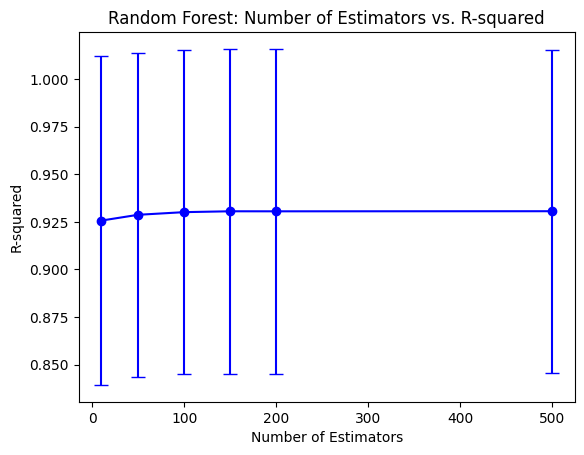

In [ ]:
# Cross Validation

# Define predictor variables and target variable
X = data_cleaned[['Sales (Global Ultimate Total USD)', 'Sum_of_employees', 'Employee_efficiency_ratio', 'Same_ultimate', 'Is_Mature']]
y = data_cleaned['Sales (Domestic Ultimate Total USD)']

# Define a range of values for the number of estimators
estimator_range = [10, 50, 100, 150, 200, 500]

# Initialize lists to store mean and standard deviation of R-squared for each number of estimators
r2_mean_values = []
r2_std_values = []

# Define cross-validation strategy (e.g., 5-fold cross-validation)
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation for each number of estimators
for n_estimators in estimator_range:
    model = RandomForestRegressor(n_estimators=n_estimators, random_state=42)
    r2_scores = cross_val_score(model, X, y, cv=cv, scoring='r2', n_jobs=-1)

    r2_mean = np.mean(r2_scores)
    r2_std = np.std(r2_scores)

    r2_mean_values.append(r2_mean)
    r2_std_values.append(r2_std)


# Plot the mean R-squared values for each number of estimators
plt.errorbar(estimator_range, r2_mean_values, yerr=r2_std_values, fmt='-o', color='b', capsize=5)
plt.title('Random Forest: Number of Estimators vs. R-squared')
plt.xlabel('Number of Estimators')
plt.ylabel('R-squared')

plt.show()

####Analysis from Plot
### This plot tells us that number of estimators above 100 is has diminishing returns on the r-squared value, which is not worth overfitting the model for. Hence, we decided to use 100 estimators.

#IMPORTANT: Please run this cell to train model to make predictions in testing_hidden_data

In [ ]:
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X, y)



RandomForestRegressor(random_state=42)

## The cell below is **NOT** to be removed
##### The function is to be amended so that it accepts the given input (dataframe) and returns the required output (list).
##### It is recommended to test the function out prior to submission
-------------------------------------------------------------------------------------------------------------------------------
##### The hidden_data parsed into the function below will have the same layout columns wise as the dataset *SENT* to you
##### Thus, ensure that steps taken to modify the initial dataset to fit into the model are also carried out in the function below

# PLEASE RUN THE CELLS ABOVE TO TRAIN THE MODEL!! THANK YOU

In [ ]:
def testing_hidden_data(hidden_data: pd.DataFrame) -> list:
    '''DO NOT REMOVE THIS FUNCTION.

The function accepts a dataframe as input and return an iterable (list)
of binary classes as output.

The function should be coded to test on hidden data
and should include any preprocessing functions needed for your model to perform.

All relevant code MUST be included in this function.'''

    data = hidden_data
    #takes in hidden_data and does same preprocessing steps

    # Section A: Cleaning Data
    missing_values = data.isnull().mean() * 100
    columns_to_remove = missing_values[missing_values > 50].index.tolist()
    columns_to_impute = missing_values[(missing_values > 0) & (missing_values <= 50)].index.tolist()
    for col in columns_to_impute:
        if data[col].dtype in ['int64', 'float64']:
            data[col].fillna(data[col].median(), inplace=True)
    for col in columns_to_impute:
        if data[col].dtype == 'object':
            data[col].fillna(data[col].mode()[0], inplace=True)
    data_cleaned = data.drop(columns=columns_to_remove)

    # Section B: Feature Engineering
    data_cleaned['Sum_of_employees'] = data_cleaned.groupby('Domestic Ultimate Company')['Employees (Single Site)'].transform('sum') + data_cleaned['Employees (Global Ultimate Total)']
    data_cleaned['Employee_efficiency_ratio'] = data_cleaned['Sales (Global Ultimate Total USD)'] / data_cleaned['Sum_of_employees']
    data_cleaned["Same_ultimate"] = data_cleaned.apply(lambda row: 1 if row['Global Ultimate Company'] == row['Domestic Ultimate Company'] else 0, axis=1)
    data_cleaned["Age"] = 2024 - data_cleaned["Year Found"]
    bins = [0,5, float("inf")]
    labels = ['Start-up', 'Mature']
    data_cleaned['Maturity'] = pd.cut(data_cleaned['Age'], bins=bins, labels=labels, right=False, ordered = True)
    data_cleaned["Is_Mature"] = np.where(data_cleaned['Maturity'] == 'Mature', 1, 0)

    # generate predictions on hidden_data (stored in result)
    # IMPORTANT NOTE: Our model is trained in the cell above.
    test_features = data_cleaned[['Sales (Global Ultimate Total USD)', 'Sum_of_employees', 'Employee_efficiency_ratio', 'Same_ultimate', 'Is_Mature']]
    predictions = model.predict(test_features)
    result = predictions.tolist()

    return result

##### Cell to check testing_hidden_data function

In [ ]:
# This cell should output a list of predictions.

test_df = pd.read_csv(filepath)
test_df = test_df.drop(columns=['Sales (Domestic Ultimate Total USD)'])
print(testing_hidden_data(test_df))

[3654878.55, 7093536000.0, 13688028.978, 73398976000.0, 432388.69, 1026308.0, 4739887111.48, 1049146.4845174944, 66597655.49, 342441000.0, 8014011.0, 9370254.26, 1026308.0, 635649.0, 2142745.44, 6062458.0, 18640104.06, 22875134.52443398, 441376.0, 630866949.0, 8916616.61, 18443540.0, 2445312.3, 33980528.0, 1026308.0, 1026308.0, 521364.0, 112419708.29, 384985.0, 330643.19, 10865038.19, 1026308.0, 1026308.0, 16545888.419746691, 1026308.0, 1026308.0, 26796510.18, 6985536.09, 7697334.8, 1026308.0, 1026308.0, 739399942.005, 1179314000.0, 7989071.69, 1049146.4845174944, 318049643438.7902, 1026308.0, 381784.0, 147815.0, 254188288.0, 1026308.0, 5187989.65, 16286304.397957595, 2565770.0, 1026308.0, 425757461.12, 94758713.0, 1026308.0, 1026308.0, 2148223313.0459995, 34471537.38, 53276742.74, 126353290.25, 1026308.0, 251017312.0, 2361131.0784761896, 1401900.0, 446382.46, 8980164.54, 16916896.361128204, 4468931.06, 33702260.41, 4646684.06, 1026308.0, 12436034.88, 6515481.34, 13076800.0, 1026308.0,

### Please have the filename renamed and ensure that it can be run with the requirements above being met. All the best!